# Interpretability: Inferring importances for GO and genes

NetworkVI is a Variational Autoencoder for the paired and mosaic integration of multimodal single-cell data. Each single-cell modality is learned in individual encoders; the latent spaces are then aligned for a joint representation. In this notebook we demonstrate how to use the inherent interpretability of NetworkVI to infer importances for GO terms and genes. We use a publically available CITE-seq dataset created by {cite}`Luecken2021`.

If you use NetworkVI, please consider citing:

Arnoldt, L., Upmeier zu Belzen, J., Herrmann, L., Nguyen, K., Theis, F.J., Wild, B. , Eils, R., "Biologically Guided Variational Inference for Interpretable Multimodal Single-Cell Integration and Mechanistic Discovery", bioRxiv, June 2025.

In [1]:
import os
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !pip install networkvi

In [87]:
import numpy as np
import requests
import sys
sys.path.append("../../../src")
import networkvi
from networkvi.model import NETWORKVI
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.preprocessing import normalize
import seaborn as sns
import pandas as pd
from goatools.obo_parser import GODag
import shutil

In [ ]:
%%capture
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
%matplotlib inline

In [4]:
r = requests.get("http://purl.obolibrary.org/obo/go/go-basic.obo", allow_redirects=True)
open(os.path.join("../../../resources/", "go-basic.obo"), 'wb').write(r.content)

31220894

In [5]:
if not os.path.isfile("../../../gene_interactions.csv"):
    import gdown
    gdown.download("https://drive.google.com/uc?export=download&id=1MwAuqw2JVl6L9xfsWGfUH7rB02LsQ_Vv", "../../../gene_interactions.csv")

## Data loading

We provide a subsetted and preprocessed version of the CITE-seq and Multiome dataset for this tutorial. We filtered low qualty cells, lowly expressed features and performed subsampling to 5000 cells and feature subselection to 4000 highly variable genes and 20000 highly variable ATAC peaks. NetworkVI accepts raw counts data for all modalities. For details on the preprocessing please refer to the manuscript and the code in the [NetworkVI reproducibility repository](https://github.com/LArnoldt/networkvi_reproducibility). In the repository we also provide scripts for downloading and processing the datasets used in the manuscript. The original CITE-seq dataset contains 90261 bone marrow mononuclear cells inferred at 4 different sites with 13953 genes and 143 proteins.

In [6]:
rna_cite_path = "neurips2021_cite_bmmc_luecken2021.h5ad"

try:
    rna_cite = sc.read_h5ad(rna_cite_path)
except OSError:
    import gdown

    gdown.download("https://drive.google.com/uc?export=download&id=1A9o8wZgWS6udFMXJ-ybXre1dCcCdsKt5")
    rna_cite = sc.read_h5ad(rna_cite_path)

rna_cite

AnnData object with n_obs × n_vars = 5000 × 4000
    obs: 'cell_type', 'Site', 'DonorID'
    var: 'gene_stable_id', 'modality'
    uns: 'protein_expression'
    obsm: 'protein_expression'

## Data setup

To perform query-to-reference mapping, we select the cells inferred at one of the four different sites as the query dataset. We train NetworkVI on the rest of the dataset.

In [7]:
adata = rna_cite
query = adata[adata.obs["Site"] == "site1"].copy()
adata = adata[adata.obs["Site"] != "site1"].copy()

We register the fields and setup the anndata with a convenience function as shown below. NetworkVI requires as MultiVi to register the modality as the batch_key. Further batch information can be registered as categorical_covariate_keys.

In [8]:
NETWORKVI.setup_anndata(
    adata,
    batch_key="Site",
    protein_expression_obsm_key="protein_expression",
)

INFO     Generating sequential column names                                                                        


## Model setup and training

We demonstrate the setup and training of NetworkVI, which makes use of the Gene Ontology, as the encoder structure. Below we define a convenience function to get the latent representation and to visualize the latent space. NetworkVI requires as MultiVI the definition of the number of features per modality (n_genes, n_proteins, n_regions).

In [9]:
def get_plot_latent_representation(vae, adata):
    latent_representation = vae.get_latent_representation(modality="joint")
    adata.obsm["X_NetworkVI"] = latent_representation
    sc.pp.neighbors(adata, use_rep="X_NetworkVI")
    sc.tl.umap(adata, n_components=2)
    return adata

### NetworkVI

We select NetworkVI by setting layers_encoder_type to "go". The mapping of the features to the gene layer and the Gene Ontology requires ENSEMBL-IDs, which we provide in ensembl_ids_genes and ensembl_ids_proteins. We also provide the Gene Ontology and a gene-to-GO mapping file in obo_file and map_ensembl_go. Please don't use the provided mapping file in production since it's an artifically subsampled version of a real mapping file. Please refer to the scripts provided in https://github.com/Larnoldt/networkvi_reproducibility or https://geneontology.org/docs/go-annotation-file-gaf-format-2.1/ to download full mapping files.

In [10]:
vae = NETWORKVI(
    adata,
    n_genes=len(adata.var[adata.var["modality"] == "Gene Expression"]),
    n_proteins=adata.obsm["protein_expression"].shape[1],
    ensembl_ids_genes=np.array(adata.var[adata.var["modality"] == "Gene Expression"]["gene_stable_id"]),
    ensembl_ids_proteins=np.array(adata.uns["protein_expression"]["var"]["gene_stable_id"]),
    gene_layer_interaction_source="../../../gene_interactions.csv",
    expression_gene_layer_type="interaction",
    protein_gene_layer_type="interaction",
    obo_file="../../../resources/go-basic.obo",
    map_ensembl_go=["../../../resources/ensembl2go.gaf"],
    layers_encoder_type="go",
    encode_covariates=True,
    deeply_inject_covariates=True,
    fully_paired=True,
    standard_gene_size=5,
    standard_go_size=2,
)

vae.train(max_epochs=10, adversarial_mixing=False, save_best=False)

INFO     Prepared gene object.                                                                                     
../../../resources/go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms; optional_attrs(relationship)
../../../resources/go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms; optional_attrs(relationship)
INFO     Before filtering:                                                                                         
INFO                                                                                                               
         GO object with 26554 GOTerms.                                                                             
INFO                                                                                                               
         Depth distribution (using is_a only):                                                                     
INFO                                                                                                  

/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/torch/nn/init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


../../../resources/go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms; optional_attrs(relationship)
../../../resources/go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms; optional_attrs(relationship)
INFO     Before filtering:                                                                                         
INFO                                                                                                               
         GO object with 26554 GOTerms.                                                                             
INFO                                                                                                               
         Depth distribution (using is_a only):                                                                     
INFO                                                                                                               
         |----------|---|----|-----|------|------|------|------|------|------|------|------|-----|----

/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_to ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_to ...
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/ligh

Epoch 10/10: 100%|██████████| 10/10 [01:32<00:00,  9.22s/it, v_num=1, train_loss_step=1.09e+4, train_loss_epoch=4.76e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [01:32<00:00,  9.29s/it, v_num=1, train_loss_step=1.09e+4, train_loss_epoch=4.76e+3]


We can visualize the generated latent space:

In [11]:
adata = get_plot_latent_representation(vae, adata)

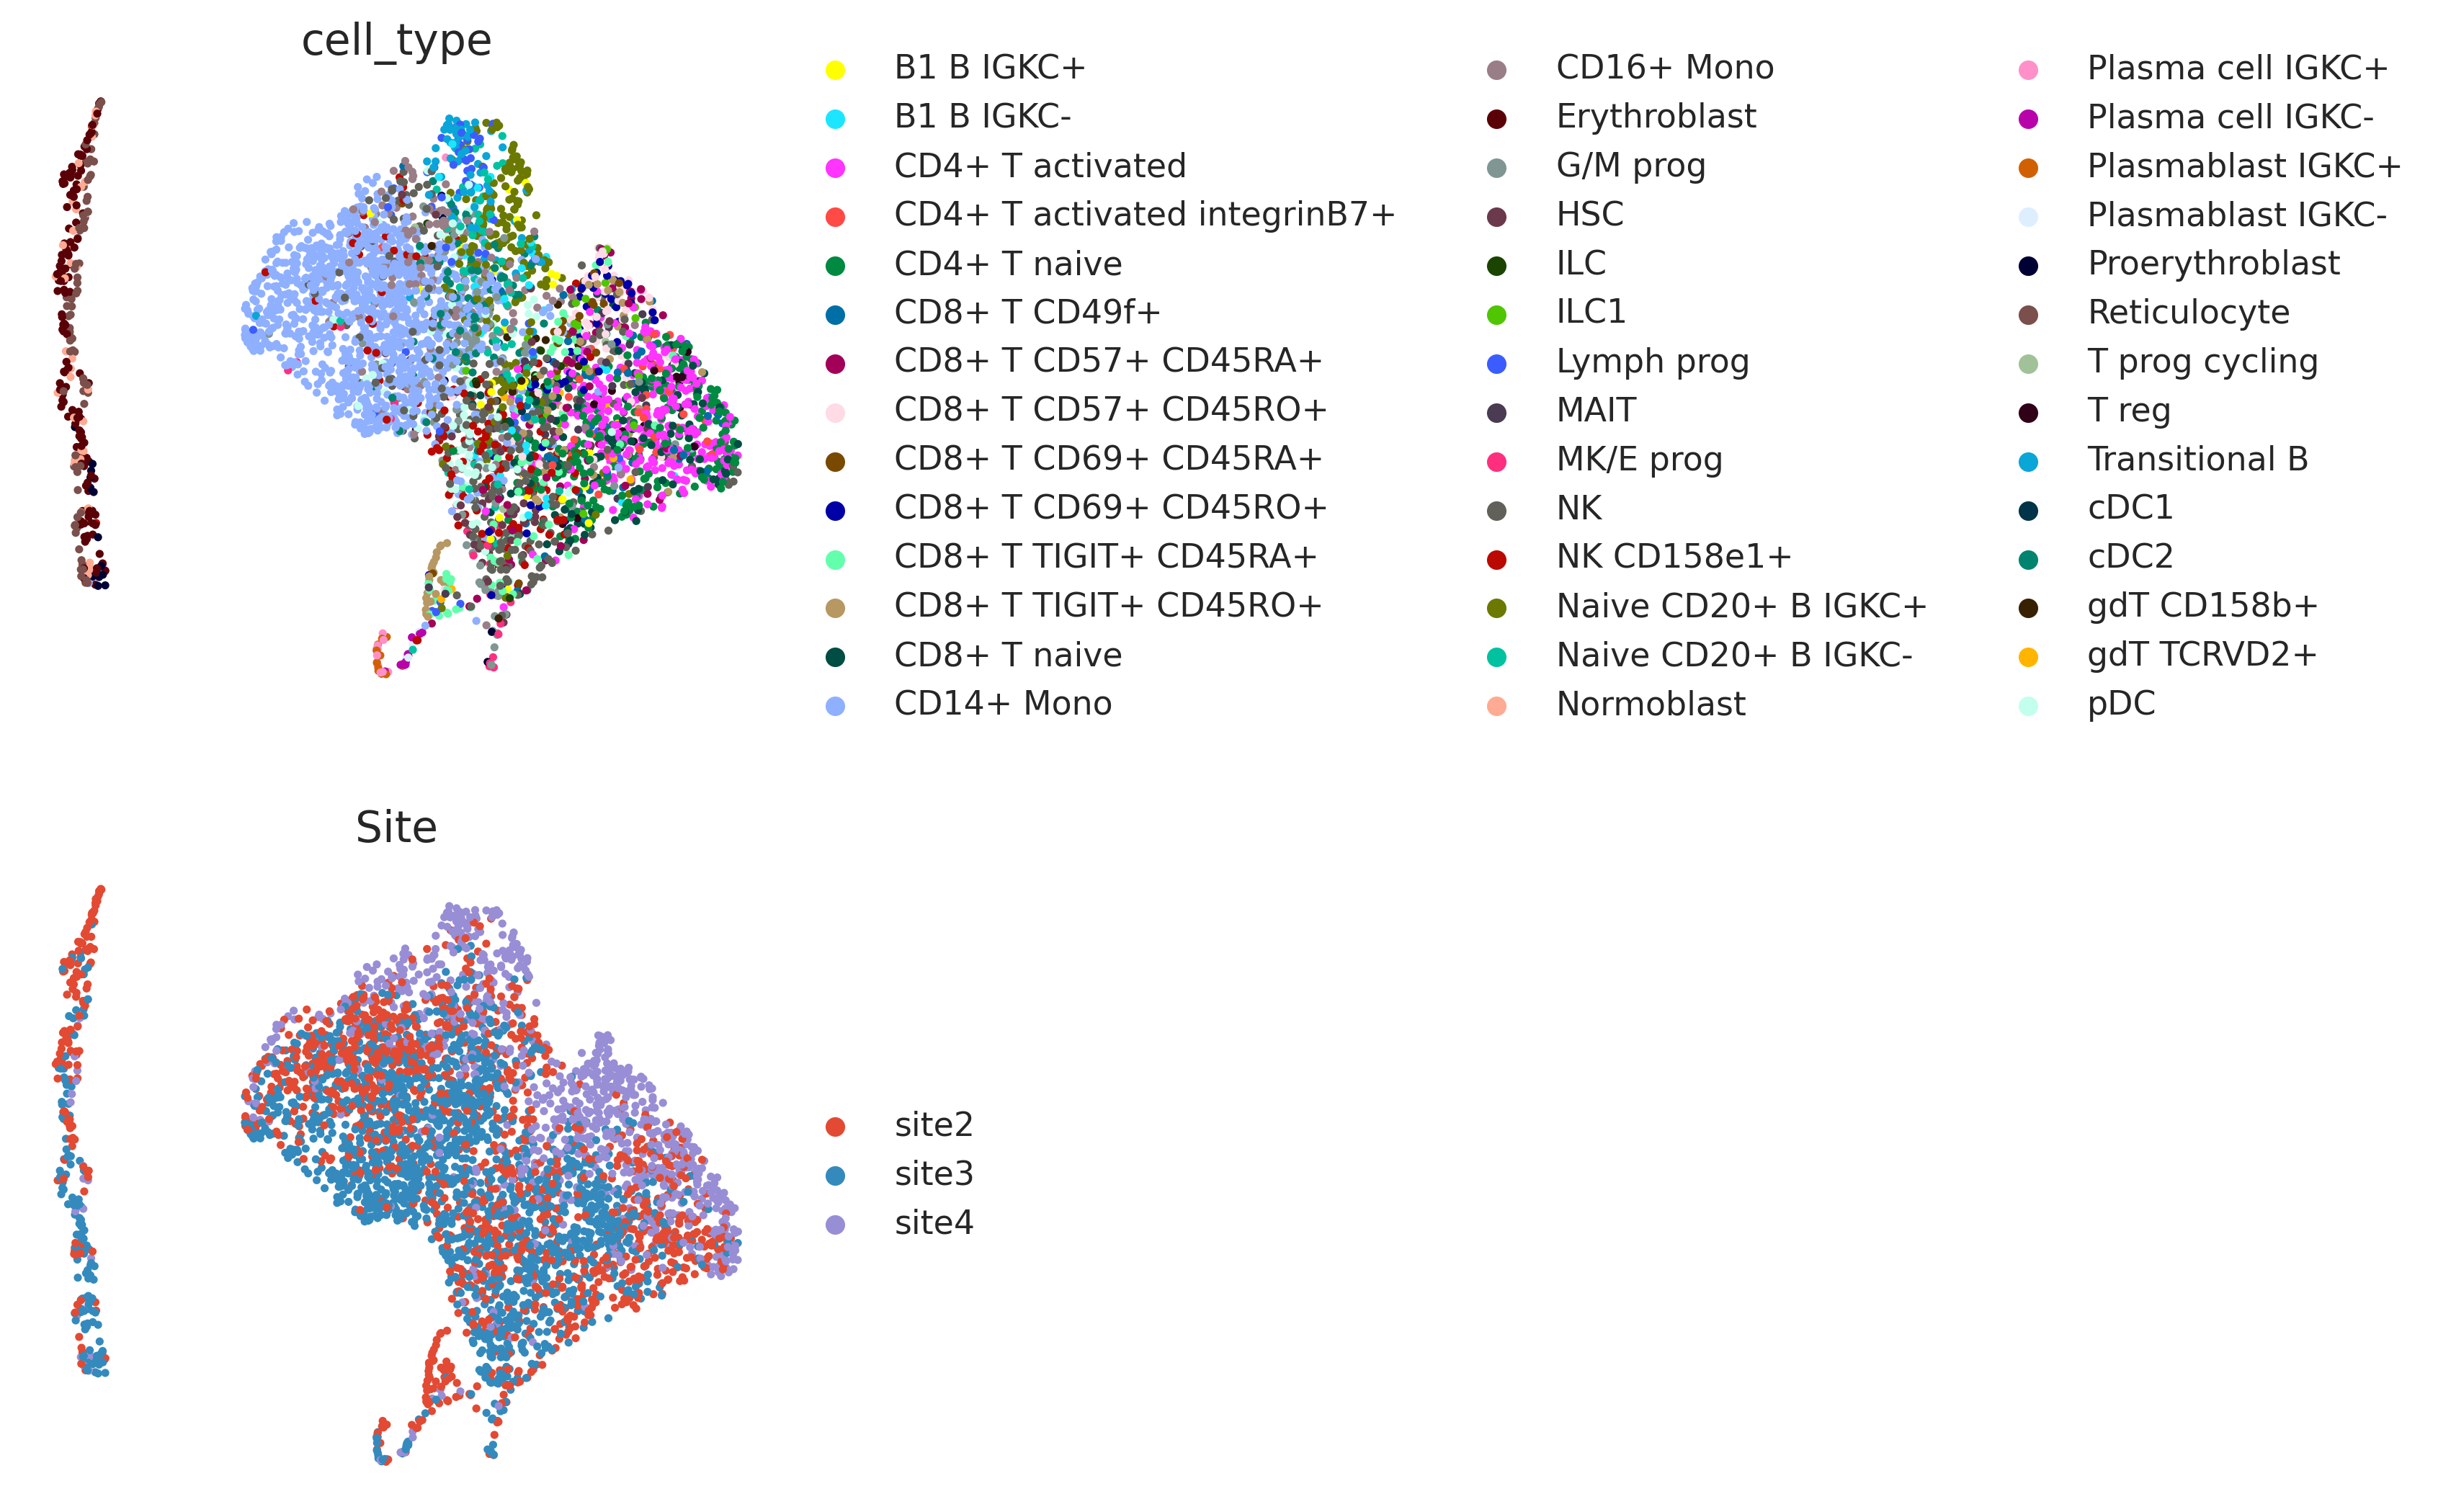

In [12]:
sc.pl.umap(adata, color=["cell_type", "Site"], frameon=False, ncols=1)

## Interpretability

By fitting a Logistic Regression on the activations of the nodes representing a GO term (calc_go_terms), a gene (calc_genes) or a gene_group (calc_gene_groups) we may infer the importance of this node for the performance of the neural network as described previously by {cite}`Ma2018`. Here, we demonstrate how to utilize the get_go_gene_importances and get_perturbation_go_gene_importances functions to infer the importances for the original dataset and for perturbed datasets in a sensitivity analysis. The importance is calculated in standard mode for each label against the rest. Using labels_selection, labels_selection_groups, restrict_by_column_key_activations_mask, restrict_by_column_values_activations_mask and comparison this behaviour may be modified. Please refer to the API documentation.

In [19]:
obodag = GODag(os.path.join("../../../resources/", "go-basic.obo"))

../../../resources/go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms


In [14]:
_ = vae.get_go_gene_importances(labels_column="cell_type",
                                results_dir=f"tutorial/calc_go_terms",
                                shuffle_set_split=False,
                                batch_size=512,
                                calc_go_terms=True,
                                calc_genes=False,
                                calc_gene_groups=False,
                                save_fit=False)

0it [00:00, ?it/s]
  0%|          | 0/42 [00:00<?, ?it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 13%|█▎        | 4/30 [00:00<00:00, 33.63it/s]

 27%|██▋       | 8/30 [00:00<00:00, 35.69it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed t

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




  2%|▏         | 1/42 [00:01<00:52,  1.28s/it]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 44.34it/s]

 33%|███▎      | 10/30 [00:00<00:00, 43.97it/s]

 50%|█████     | 15/30 [00:00<00:00, 44.23it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 38.71it/s]

 80%|████████  | 24/30 [00:00<00:00, 38.35it/s]

 97%|█████████▋| 29/30 [00:00<00:00, 36.53it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of 

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




  5%|▍         | 2/42 [00:02<00:51,  1.29s/it]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 43.65it/s]

 33%|███▎      | 10/30 [00:00<00:00, 42.85it/s]

 50%|█████     | 15/30 [00:00<00:00, 43.71it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 39.03it/s]

 80%|████████  | 24/30 [00:00<00:00, 38.80it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 97%|█████████▋| 29/30 [00:00<00:00, 34.75it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of 

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




  7%|▋         | 3/42 [00:03<00:51,  1.32s/it]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 45.15it/s]

 33%|███▎      | 10/30 [00:00<00:00, 43.57it/s]

 50%|█████     | 15/30 [00:00<00:00, 44.10it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 37.58it/s]

 80%|████████  | 24/30 [00:00<00:00, 37.11it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 97%|█████████▋| 29/30 [00:00<00:00, 35.62it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of 

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 10%|▉         | 4/42 [00:05<00:48,  1.27s/it]/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 41.32it/s]

 33%|███▎      | 10/30 [00:00<00:00, 42.61it/s]

 50%|█████     | 15/30 [00:00<00:00, 43.67it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 38.36it/s]

 80%|████████  | 24/30 [00:00<00:00, 38.47it/s]

 97%|█████████▋| 29/30 [00:00<00:00, 36.28it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of 

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 12%|█▏        | 5/42 [00:06<00:46,  1.25s/it]/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 45.76it/s]

 33%|███▎      | 10/30 [00:00<00:00, 46.10it/s]

 50%|█████     | 15/30 [00:00<00:00, 46.03it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 40.41it/s]

 83%|████████▎ | 25/30 [00:00<00:00, 40.38it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 14%|█▍        | 6/42 [00:07<00:44,  1.24s/it]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 43.99it/s]

 33%|███▎      | 10/30 [00:00<00:00, 44.71it/s]

 50%|█████     | 15/30 [00:00<00:00, 45.53it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 38.95it/s]

 83%|████████▎ | 25/30 [00:00<00:00, 38.92it/s]

 97%|█████████▋| 29/30 [00:00<00:00, 36.95it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of 

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 21%|██▏       | 9/42 [00:08<00:24,  1.33it/s]/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 13%|█▎        | 4/30 [00:00<00:00, 39.38it/s]

 27%|██▋       | 8/30 [00:00<00:00, 39.72it/s]

 43%|████▎     | 13/30 [00:00<00:00, 41.33it/s]

 60%|██████    | 18/30 [00:00<00:00, 41.60it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 77%|███████▋  | 23/30 [00:00<00:00, 33.64it/s]

 93%|█████████▎| 28/30 [00:00<00:00, 36.30it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of i

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 26%|██▌       | 11/42 [00:10<00:21,  1.43it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 42.00it/s]

 33%|███▎      | 10/30 [00:00<00:00, 43.40it/s]

 50%|█████     | 15/30 [00:00<00:00, 44.30it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 38.27it/s]

 80%|████████  | 24/30 [00:00<00:00, 37.67it/s]

 97%|█████████▋| 29/30 [00:00<00:00, 36.01it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of 

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 29%|██▊       | 12/42 [00:11<00:23,  1.25it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 13%|█▎        | 4/30 [00:00<00:00, 34.98it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 27%|██▋       | 8/30 [00:00<00:00, 36.07it/s]

 40%|████      | 12/30 [00:00<00:00, 36.71it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 53%|█████▎    | 16/30 [00:00<00:00, 36.51it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnold

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 31%|███       | 13/42 [00:12<00:26,  1.11it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 44.36it/s]

 33%|███▎      | 10/30 [00:00<00:00, 43.97it/s]

 50%|█████     | 15/30 [00:00<00:00, 45.54it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 40.44it/s]

 83%|████████▎ | 25/30 [00:00<00:00, 40.11it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 33%|███▎      | 14/42 [00:13<00:27,  1.03it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 43.99it/s]

 33%|███▎      | 10/30 [00:00<00:00, 43.93it/s]

 50%|█████     | 15/30 [00:00<00:00, 44.97it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 39.78it/s]

 83%|████████▎ | 25/30 [00:00<00:00, 39.43it/s]

 97%|█████████▋| 29/30 [00:00<00:00, 37.32it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of 

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 36%|███▌      | 15/42 [00:14<00:27,  1.03s/it]/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 45.07it/s]

 33%|███▎      | 10/30 [00:00<00:00, 43.44it/s]

 50%|█████     | 15/30 [00:00<00:00, 44.16it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 38.41it/s]

 80%|████████  | 24/30 [00:00<00:00, 37.79it/s]

 97%|█████████▋| 29/30 [00:00<00:00, 36.44it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of 

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 38%|███▊      | 16/42 [00:16<00:28,  1.10s/it]/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:


Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]]
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:917: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_eval = (labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]]


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 45.56it/s]

 33%|███▎      | 10/30 [00:00<00:00, 44.33it/s]

 50%|█████     | 15/30 [00:00<00:00, 44.89it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 39.01it/s]

 83%|████████▎ | 25/30 [00:00<00:00, 38.64it/s]

 97%|█████████▋| 29/30 [00:00<00:00, 36.52it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of 

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 40%|████      | 17/42 [00:17<00:28,  1.13s/it]/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 44.87it/s]

 33%|███▎      | 10/30 [00:00<00:00, 44.14it/s]

 50%|█████     | 15/30 [00:00<00:00, 44.85it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 38.82it/s]

 80%|████████  | 24/30 [00:00<00:00, 38.93it/s]

 97%|█████████▋| 29/30 [00:00<00:00, 35.08it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of 

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 43%|████▎     | 18/42 [00:18<00:27,  1.16s/it]/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 43.84it/s]

 33%|███▎      | 10/30 [00:00<00:00, 45.49it/s]

 50%|█████     | 15/30 [00:00<00:00, 45.49it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 40.25it/s]

 83%|████████▎ | 25/30 [00:00<00:00, 40.16it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 48%|████▊     | 20/42 [00:19<00:19,  1.10it/s]/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 45.51it/s]

 33%|███▎      | 10/30 [00:00<00:00, 46.56it/s]

 50%|█████     | 15/30 [00:00<00:00, 46.60it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 40.41it/s]

 83%|████████▎ | 25/30 [00:00<00:00, 40.55it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 50%|█████     | 21/42 [00:21<00:23,  1.11s/it]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 42.30it/s]

 33%|███▎      | 10/30 [00:00<00:00, 43.89it/s]

 50%|█████     | 15/30 [00:00<00:00, 44.81it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 40.29it/s]

 83%|████████▎ | 25/30 [00:00<00:00, 39.82it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 52%|█████▏    | 22/42 [00:22<00:22,  1.14s/it]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 43.50it/s]

 33%|███▎      | 10/30 [00:00<00:00, 43.11it/s]

 50%|█████     | 15/30 [00:00<00:00, 44.19it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 38.34it/s]

 80%|████████  | 24/30 [00:00<00:00, 37.59it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 97%|█████████▋| 29/30 [00:00<00:00, 36.00it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of 

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 55%|█████▍    | 23/42 [00:23<00:22,  1.17s/it]/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 45.55it/s]

 33%|███▎      | 10/30 [00:00<00:00, 44.72it/s]

 50%|█████     | 15/30 [00:00<00:00, 45.90it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 38.66it/s]

 83%|████████▎ | 25/30 [00:00<00:00, 38.59it/s]

 97%|█████████▋| 29/30 [00:00<00:00, 36.39it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of 

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 57%|█████▋    | 24/42 [00:25<00:21,  1.19s/it]/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 13%|█▎        | 4/30 [00:00<00:00, 35.87it/s]

 27%|██▋       | 8/30 [00:00<00:00, 37.44it/s]

 40%|████      | 12/30 [00:00<00:00, 37.90it/s]

 53%|█████▎    | 16/30 [00:00<00:00, 38.68it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnold

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 60%|█████▉    | 25/42 [00:26<00:20,  1.19s/it]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 45.18it/s]

 33%|███▎      | 10/30 [00:00<00:00, 44.77it/s]

 50%|█████     | 15/30 [00:00<00:00, 45.37it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 39.05it/s]

 83%|████████▎ | 25/30 [00:00<00:00, 39.04it/s]

 97%|█████████▋| 29/30 [00:00<00:00, 36.61it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of 

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 62%|██████▏   | 26/42 [00:27<00:19,  1.21s/it]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 43.53it/s]

 33%|███▎      | 10/30 [00:00<00:00, 42.49it/s]

 50%|█████     | 15/30 [00:00<00:00, 43.22it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 36.86it/s]

 80%|████████  | 24/30 [00:00<00:00, 36.87it/s]

 97%|█████████▋| 29/30 [00:00<00:00, 34.97it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of 

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 64%|██████▍   | 27/42 [00:28<00:18,  1.22s/it]/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 42.55it/s]

 33%|███▎      | 10/30 [00:00<00:00, 43.13it/s]

 50%|█████     | 15/30 [00:00<00:00, 44.31it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 38.59it/s]

 80%|████████  | 24/30 [00:00<00:00, 38.77it/s]

 97%|█████████▋| 29/30 [00:00<00:00, 36.50it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of 

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 67%|██████▋   | 28/42 [00:30<00:17,  1.24s/it]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 45.77it/s]

 33%|███▎      | 10/30 [00:00<00:00, 44.76it/s]

 50%|█████     | 15/30 [00:00<00:00, 45.68it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 39.28it/s]

 83%|████████▎ | 25/30 [00:00<00:00, 38.79it/s]

 97%|█████████▋| 29/30 [00:00<00:00, 37.31it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of 

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 69%|██████▉   | 29/42 [00:31<00:15,  1.23s/it]/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 39.45it/s]

 33%|███▎      | 10/30 [00:00<00:00, 41.18it/s]

 50%|█████     | 15/30 [00:00<00:00, 41.76it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 36.38it/s]

 80%|████████  | 24/30 [00:00<00:00, 36.72it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 97%|█████████▋| 2

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 71%|███████▏  | 30/42 [00:32<00:14,  1.24s/it]/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 41.97it/s]

 33%|███▎      | 10/30 [00:00<00:00, 42.26it/s]

 50%|█████     | 15/30 [00:00<00:00, 43.28it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 38.05it/s]

 80%|████████  | 24/30 [00:00<00:00, 37.56it/s]

 97%|█████████▋| 29/30 [00:00<00:00, 35.68it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of 

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 74%|███████▍  | 31/42 [00:33<00:13,  1.24s/it]/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 44.79it/s]

 33%|███▎      | 10/30 [00:00<00:00, 43.91it/s]

 50%|█████     | 15/30 [00:00<00:00, 44.79it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 38.23it/s]

 80%|████████  | 24/30 [00:00<00:00, 37.57it/s]

 97%|█████████▋| 29/30 [00:00<00:00, 35.56it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of 

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 76%|███████▌  | 32/42 [00:35<00:12,  1.23s/it]/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 13%|█▎        | 4/30 [00:00<00:00, 37.88it/s]

 27%|██▋       | 8/30 [00:00<00:00, 37.57it/s]

 43%|████▎     | 13/30 [00:00<00:00, 39.25it/s]

 57%|█████▋    | 17/30 [00:00<00:00, 39.33it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 70%|███████   | 21/30 [00:00<00:00, 32.88it/s]

 83%|████████▎ | 25/30 [00:00<00:00, 34.44it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of i

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 79%|███████▊  | 33/42 [00:36<00:11,  1.24s/it]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 44.59it/s]

 33%|███▎      | 10/30 [00:00<00:00, 44.32it/s]

 50%|█████     | 15/30 [00:00<00:00, 45.04it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 67%|██████▋   | 20/30 [00:00<00:00, 36.55it/s]

 80%|████████  | 24/30 [00:00<00:00, 36.71it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 97%|█████████▋| 2

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 81%|████████  | 34/42 [00:37<00:09,  1.21s/it]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 41.15it/s]

 33%|███▎      | 10/30 [00:00<00:00, 42.93it/s]

 50%|█████     | 15/30 [00:00<00:00, 43.74it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 37.00it/s]

 80%|████████  | 24/30 [00:00<00:00, 36.69it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 97%|█████████▋| 29/30 [00:00<00:00, 35.02it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of 

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 83%|████████▎ | 35/42 [00:38<00:08,  1.22s/it]/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 45.20it/s]

 33%|███▎      | 10/30 [00:00<00:00, 44.31it/s]

 50%|█████     | 15/30 [00:00<00:00, 44.94it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 40.03it/s]

 83%|████████▎ | 25/30 [00:00<00:00, 39.43it/s]

 97%|█████████▋| 29/30 [00:00<00:00, 36.93it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of 

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 86%|████████▌ | 36/42 [00:40<00:07,  1.24s/it]/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 13%|█▎        | 4/30 [00:00<00:00, 35.56it/s]

 27%|██▋       | 8/30 [00:00<00:00, 37.96it/s]

 43%|████▎     | 13/30 [00:00<00:00, 39.29it/s]

 60%|██████    | 18/30 [00:00<00:00, 39.79it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnold

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 88%|████████▊ | 37/42 [00:41<00:06,  1.22s/it]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 43.84it/s]

 33%|███▎      | 10/30 [00:00<00:00, 43.04it/s]

 50%|█████     | 15/30 [00:00<00:00, 44.10it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 38.87it/s]

 80%|████████  | 24/30 [00:00<00:00, 38.50it/s]

 97%|█████████▋| 29/30 [00:00<00:00, 36.91it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of 

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 90%|█████████ | 38/42 [00:42<00:04,  1.21s/it]/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 43.85it/s]

 33%|███▎      | 10/30 [00:00<00:00, 43.39it/s]

 50%|█████     | 15/30 [00:00<00:00, 43.98it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 38.52it/s]

 80%|████████  | 24/30 [00:00<00:00, 37.86it/s]

 97%|█████████▋| 29/30 [00:00<00:00, 35.78it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of 

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 93%|█████████▎| 39/42 [00:43<00:03,  1.23s/it]/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 43.61it/s]

 33%|███▎      | 10/30 [00:00<00:00, 43.30it/s]

 50%|█████     | 15/30 [00:00<00:00, 44.36it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 37.88it/s]

 80%|████████  | 24/30 [00:00<00:00, 37.36it/s]

 97%|█████████▋| 29/30 [00:00<00:00, 36.36it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of 

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 95%|█████████▌| 40/42 [00:44<00:02,  1.22s/it]/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [00:00<00:00, 44.08it/s]

 33%|███▎      | 10/30 [00:00<00:00, 43.40it/s]

 50%|█████     | 15/30 [00:00<00:00, 44.09it/s]

 67%|██████▋   | 20/30 [00:00<00:00, 38.06it/s]

 80%|████████  | 24/30 [00:00<00:00, 38.28it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 97%|█████████▋| 29/30 [00:00<00:00, 35.21it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of 

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 98%|█████████▊| 41/42 [00:46<00:01,  1.22s/it]/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/30 [00:00<?, ?it/s]

 13%|█▎        | 4/30 [00:00<00:00, 35.26it/s]

 27%|██▋       | 8/30 [00:00<00:00, 36.72it/s]

 40%|████      | 12/30 [00:00<00:00, 36.79it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 53%|█████▎    | 16/30 [00:00<00:00, 36.77it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnold

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




100%|██████████| 42/42 [00:47<00:00,  1.13s/it]
1it [00:50, 50.96s/it]
  0%|          | 0/42 [00:00<?, ?it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 41.32it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 35.18it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 35.51it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




  2%|▏         | 1/42 [00:00<00:34,  1.20it/s]/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:


Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]]
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:917: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_eval = (labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]]


QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 44.34it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 36.47it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 37.53it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




  5%|▍         | 2/42 [00:01<00:36,  1.09it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 43.67it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 37.23it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 37.45it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




  7%|▋         | 3/42 [00:02<00:37,  1.03it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 44.80it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 35.20it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 35.85it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
100%|██████████| 17/17 [00:00<00:00, 21.62it/s]


100%|██████████| 17/17 [00:00<00:00, 47983.29it/s]


100%|██████████| 17/17 [00:00<00:00, 199728.76it/s]


100%|██████████| 17/17 [00:00<00:00, 137650.90it/s]

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 10%|▉         | 4/42 [00:03<00:35,  1.07it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 46.21it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 37.80it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 38.30it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 12%|█▏        | 5/42 [00:04<00:35,  1.05it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 45.82it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 37.62it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 38.02it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 14%|█▍        | 6/42 [00:05<00:34,  1.04it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 42.36it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 36.36it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 37.24it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 21%|██▏       | 9/42 [00:06<00:18,  1.75it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 41.98it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 59%|█████▉    | 10/17 [00:00<00:00, 33.44it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 34.83it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 26%|██▌       | 11/42 [00:07<00:16,  1.91it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 43.65it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 35.53it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 36.61it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 29%|██▊       | 12/42 [00:08<00:18,  1.63it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 44.08it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 59%|█████▉    | 10/17 [00:00<00:00, 33.30it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 34.21it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 31%|███       | 13/42 [00:09<00:19,  1.49it/s]/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:


Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]]
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:917: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_eval = (labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]]


QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 42.99it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 37.31it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 37.50it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 33%|███▎      | 14/42 [00:10<00:20,  1.34it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 42.61it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 37.28it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 37.28it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 36%|███▌      | 15/42 [00:11<00:21,  1.24it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 43.26it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 34.88it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 35.58it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 38%|███▊      | 16/42 [00:12<00:21,  1.21it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 42.44it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 35.34it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 36.01it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 40%|████      | 17/42 [00:13<00:21,  1.14it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 45.73it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 37.87it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 38.31it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 43%|████▎     | 18/42 [00:14<00:21,  1.12it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 44.42it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 37.75it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 38.59it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 48%|████▊     | 20/42 [00:15<00:15,  1.40it/s]/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:


Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]]
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:917: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_eval = (labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]]


QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 45.44it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 37.93it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 38.05it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 50%|█████     | 21/42 [00:16<00:16,  1.27it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 44.11it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 36.08it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 36.81it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 52%|█████▏    | 22/42 [00:17<00:16,  1.20it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 43.41it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 36.68it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 36.86it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 55%|█████▍    | 23/42 [00:17<00:16,  1.16it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 43.31it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 36.57it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 36.74it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 57%|█████▋    | 24/42 [00:18<00:16,  1.12it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 40.99it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 33.44it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 34.15it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 60%|█████▉    | 25/42 [00:19<00:14,  1.15it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 46.41it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 37.71it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 38.21it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 62%|██████▏   | 26/42 [00:20<00:14,  1.09it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 41.88it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 36.19it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 36.83it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 64%|██████▍   | 27/42 [00:21<00:13,  1.08it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 46.22it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 37.06it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 38.09it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 67%|██████▋   | 28/42 [00:22<00:13,  1.04it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 43.02it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 36.99it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 36.97it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 69%|██████▉   | 29/42 [00:23<00:12,  1.05it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 43.87it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 35.14it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 36.64it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 71%|███████▏  | 30/42 [00:24<00:11,  1.05it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 42.25it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 36.56it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 36.24it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 74%|███████▍  | 31/42 [00:25<00:10,  1.06it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 41.37it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 36.66it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 36.08it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 76%|███████▌  | 32/42 [00:26<00:09,  1.07it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 43.88it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 34.65it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 35.11it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 79%|███████▊  | 33/42 [00:27<00:08,  1.08it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 40.78it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 34.72it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 34.62it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 81%|████████  | 34/42 [00:28<00:07,  1.11it/s]/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:


Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]]
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:917: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_eval = (labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]]


QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 41.30it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 34.50it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 36.09it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 83%|████████▎ | 35/42 [00:29<00:06,  1.12it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 43.14it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 38.10it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 37.77it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 86%|████████▌ | 36/42 [00:30<00:05,  1.09it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 41.31it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 33.99it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 34.61it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 88%|████████▊ | 37/42 [00:30<00:04,  1.13it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 43.55it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 37.69it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 37.47it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 90%|█████████ | 38/42 [00:31<00:03,  1.11it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 44.56it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 37.49it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 37.96it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 93%|█████████▎| 39/42 [00:32<00:02,  1.06it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 43.64it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 35.61it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 35.75it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 95%|█████████▌| 40/42 [00:33<00:01,  1.06it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 29%|██▉       | 5/17 [00:00<00:00, 44.80it/s]

 59%|█████▉    | 10/17 [00:00<00:00, 37.66it/s]

 82%|████████▏ | 14/17 [00:00<00:00, 38.14it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_ba

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




 98%|█████████▊| 41/42 [00:34<00:00,  1.06it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts




  0%|          | 0/17 [00:00<?, ?it/s]

 24%|██▎       | 4/17 [00:00<00:00, 39.93it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
 

WARNING  Encountered a problem for interpretability for [Errno 2] No such file or directory:                       
         'resources/genopheno/ogm_overview.html'                                                                   




100%|██████████| 42/42 [00:35<00:00,  1.18it/s]
4it [01:30, 22.51s/it]


{'expression': {}, 'protein': {}}

get_go_gene_importances saves the activations, GO importances and further information in a pandas pickle file. We then load these files and visualize the GO importance for a selection of GO terms for all available cell types.

In [83]:
go_importances = []
cell_types = []

In [62]:
for cell_type in sorted(np.unique(adata.obs["cell_type"])):
    cell_type_mod = cell_type.replace(" ", "_").replace("/", "_")
    try:
        go_importances.append(np.array(pd.read_pickle(f"./tutorial/calc_go_terms/protein_cell_type_vs_rest_{cell_type_mod}_res_unp_act_mask_False_flip_False_go_terms_evaluated_graph_csv.pkl")["predictors_label_valid_roc"]).astype("float"))
        cell_types.append(cell_type)
    except FileNotFoundError:
        continue

In [63]:
go_terms = list(pd.read_pickle(f"./tutorial/calc_go_terms/protein_cell_type_vs_rest_{cell_type_mod}_res_unp_act_mask_False_flip_False_go_terms_evaluated_graph_csv.pkl").index)
go_terms = [f"{obodag[go_term].name} ({go_term})" if go_term in obodag.keys() else go_term for go_term in go_terms]

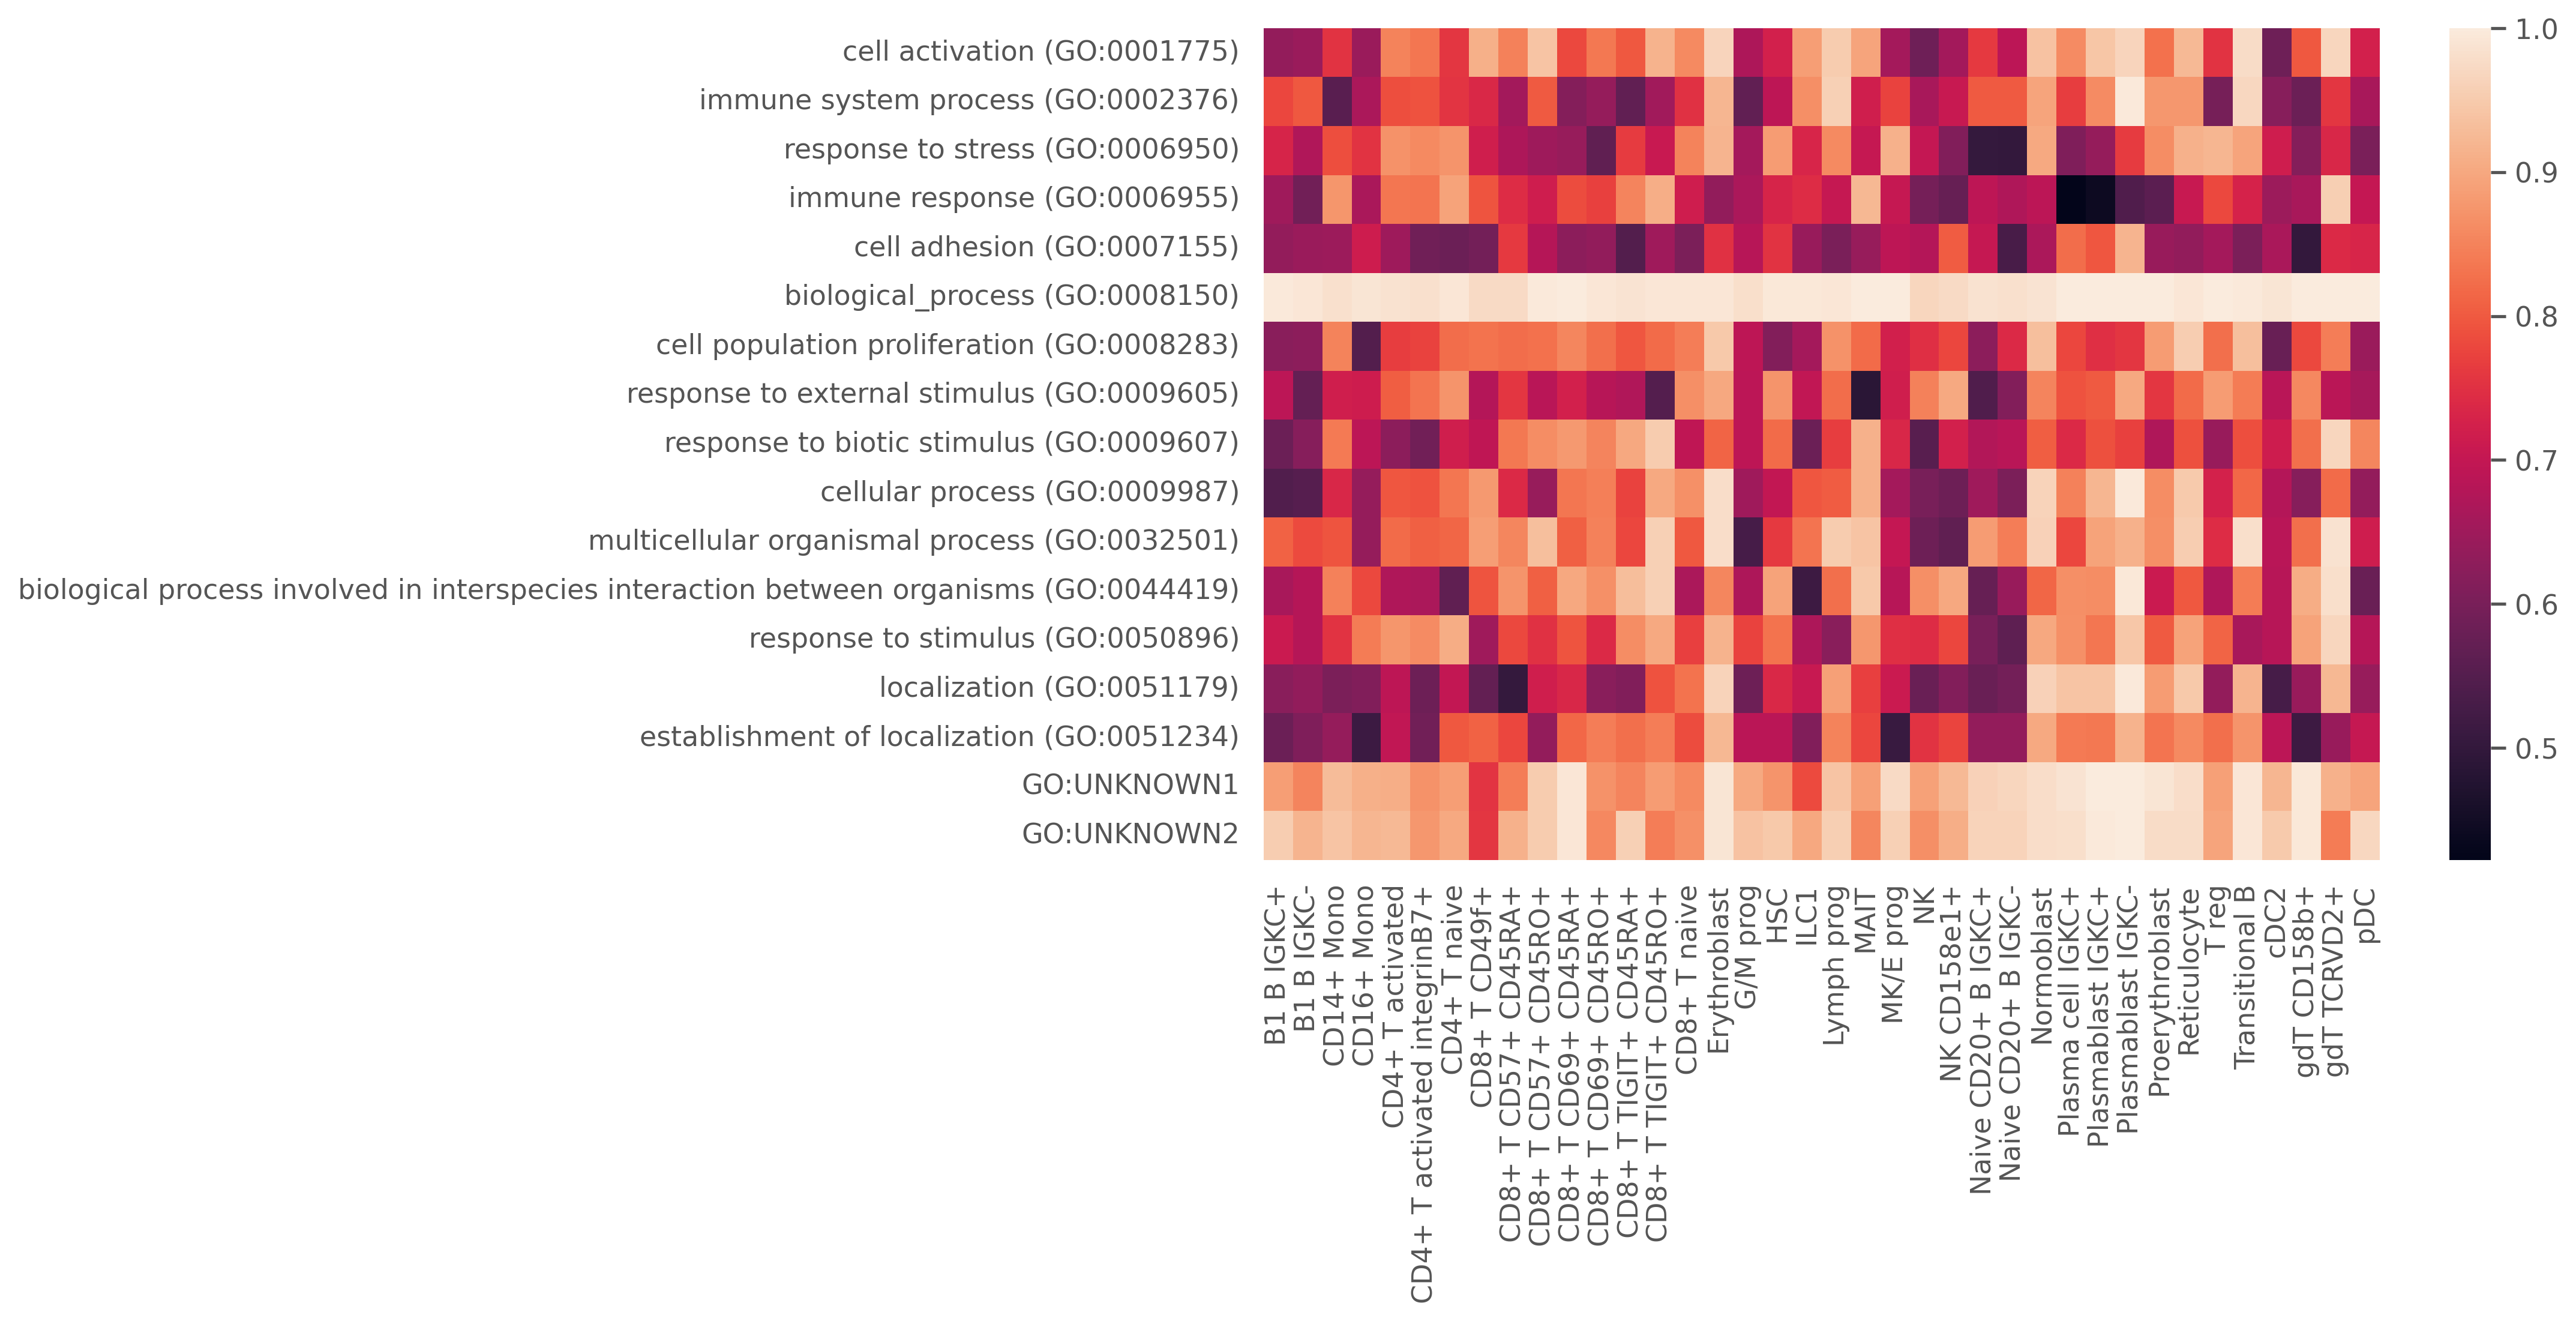

In [68]:
plt.figure(figsize=(10, 6))

sns.heatmap(np.array(go_importances).T, xticklabels=cell_types, yticklabels=go_terms)
plt.show()

In [88]:
shutil.rmtree("tutorial/calc_go_terms")

We also show how to perform a sensitivity analysis by perturbing features. Here we perturb CD86 (ENSG00000114013) by setting all values to zero. The function get_perturbation_go_gene_importances internally calls get_go_gene_importances, but additionally we need to provide the modality of the features in modality_key and the ENSEMBL-IDs in gene_stable_id_key.

In [33]:
perturbation_gene_stable_ids = ["ENSG00000114013"]

go_importances_perturbation = vae.get_perturbation_go_gene_importances(labels_column="cell_type",
                                               modality_key="modality",
                                               gene_stable_id_key="gene_stable_id",
                                               perturbation_gene_stable_ids=perturbation_gene_stable_ids,
                                               batch_size=512,
                                               shuffle_set_split=False,
                                               calc_go_terms=True,
                                               calc_genes=False,
                                               calc_gene_groups=False,)

  0%|          | 0/1 [00:00<?, ?it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 13%|█▎        | 4/30 [00:00<00:00, 35.29it/s]


 27%|██▋       | 8/30 [00:00<00:00, 36.43it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear faile

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.81it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.27it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.50it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 36.19it/s]


 80%|████████  | 24/30 [00:00<00:00, 36.64it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 35.54it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.11it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.04it/s]


 50%|█████     | 15/30 [00:00<00:00, 43.88it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 39.22it/s]


 80%|████████  | 24/30 [00:00<00:00, 39.08it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<00:00, 35.12it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 45.12it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.59it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.15it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 37.61it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.17it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<00:00, 35.57it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 41.57it/s]


 33%|███▎      | 10/30 [00:00<00:00, 42.73it/s]


 50%|█████     | 15/30 [00:00<00:00, 43.83it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.43it/s]


 80%|████████  | 24/30 [00:00<00:00, 38.58it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<00:00, 36.43it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 46.14it/s]


 33%|███▎      | 10/30 [00:00<00:00, 46.27it/s]


 50%|█████     | 15/30 [00:00<00:00, 46.14it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 40.28it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 40.33it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/s

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.03it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.56it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.41it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.97it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 38.98it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.97it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 13%|█▎        | 4/30 [00:00<00:00, 39.75it/s]


 30%|███       | 9/30 [00:00<00:00, 40.56it/s]


 47%|████▋     | 14/30 [00:00<00:00, 41.63it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 63%|██████▎   | 19/30 [00:00<00:00, 35.41it/s]


 77%|███████▋  | 23/30 [00:00<00:00, 34.93it/s]


 93%|█████████▎| 28/30 [00:00<00:00, 37.44it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the numb

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 42.38it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.54it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.41it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.25it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.76it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.16it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 13%|█▎        | 4/30 [00:00<00:00, 35.43it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 27%|██▋       | 8/30 [00:00<00:00, 36.30it/s]


 40%|████      | 12/30 [00:00<00:00, 36.97it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 53%|█████▎    | 16/30 [00:00<00:00, 36.76it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_a

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.69it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.18it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.81it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 40.73it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 40.46it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/s

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.41it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.09it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.16it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 39.85it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 39.56it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/s

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 45.23it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.48it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.27it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.54it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.92it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.58it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 45.55it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.16it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.85it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.94it/s]


 80%|████████  | 24/30 [00:00<00:00, 38.30it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.61it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.95it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.88it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.62it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.67it/s]


 80%|████████  | 24/30 [00:00<00:00, 38.79it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 35.03it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 43.93it/s]


 33%|███▎      | 10/30 [00:00<00:00, 45.48it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.56it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 40.31it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 40.20it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/s

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.88it/s]


 33%|███▎      | 10/30 [00:00<00:00, 45.92it/s]


 50%|█████     | 15/30 [00:00<00:00, 46.30it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 40.35it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 40.70it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/s

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 42.47it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.84it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.83it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 40.24it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 39.82it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/s

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 43.52it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.02it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.15it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.43it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.62it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<00:00, 35.96it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 45.45it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.56it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.65it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.53it/s]


 80%|████████  | 24/30 [00:00<00:00, 38.07it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.43it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 13%|█▎        | 4/30 [00:00<00:00, 35.92it/s]


 27%|██▋       | 8/30 [00:00<00:00, 37.28it/s]


 40%|████      | 12/30 [00:00<00:00, 37.84it/s]


 53%|█████▎    | 16/30 [00:00<00:00, 38.65it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_a

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 45.49it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.69it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.37it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 39.04it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 39.05it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.73it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.04it/s]


 33%|███▎      | 10/30 [00:00<00:00, 42.81it/s]


 50%|█████     | 15/30 [00:00<00:00, 43.68it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 37.19it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.17it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<00:00, 35.09it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 43.06it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.46it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.68it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.89it/s]


 80%|████████  | 24/30 [00:00<00:00, 39.03it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.86it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 46.30it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.98it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.94it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 39.44it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 39.21it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 37.20it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 40.10it/s]


 33%|███▎      | 10/30 [00:00<00:00, 41.97it/s]


 50%|█████     | 15/30 [00:00<00:00, 42.72it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 37.12it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.41it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|██████

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 42.44it/s]


 33%|███▎      | 10/30 [00:00<00:00, 42.51it/s]


 50%|█████     | 15/30 [00:00<00:00, 43.68it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.46it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.88it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 35.94it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.81it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.96it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.86it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.38it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.72it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<00:00, 35.64it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 13%|█▎        | 4/30 [00:00<00:00, 38.06it/s]


 27%|██▋       | 8/30 [00:00<00:00, 37.64it/s]


 43%|████▎     | 13/30 [00:00<00:00, 39.44it/s]


 57%|█████▋    | 17/30 [00:00<00:00, 39.47it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 70%|███████   | 21/30 [00:00<00:00, 32.92it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 34.61it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the numb

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.94it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.32it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.11it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 67%|██████▋   | 20/30 [00:00<00:00, 36.57it/s]


 80%|████████  | 24/30 [00:00<00:00, 36.26it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|██████

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 41.49it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.17it/s]


 50%|█████     | 15/30 [00:00<00:00, 43.98it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 37.11it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.00it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 35.41it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 45.24it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.28it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.08it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 40.28it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 39.65it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/s

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 13%|█▎        | 4/30 [00:00<00:00, 35.89it/s]


 27%|██▋       | 8/30 [00:00<00:00, 38.07it/s]


 43%|████▎     | 13/30 [00:00<00:00, 39.47it/s]


 60%|██████    | 18/30 [00:00<00:00, 40.01it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_a

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.27it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.36it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.41it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 39.23it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 39.04it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.99it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.18it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.55it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.28it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.69it/s]


 80%|████████  | 24/30 [00:00<00:00, 38.03it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<00:00, 35.92it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 45.47it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.04it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.02it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.37it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.79it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.72it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.87it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.86it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.65it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.49it/s]


 80%|████████  | 24/30 [00:00<00:00, 38.77it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<00:00, 35.66it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]]
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:917: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_eval = (labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]]


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 13%|█▎        | 4/30 [00:00<00:00, 35.41it/s]


 27%|██▋       | 8/30 [00:00<00:00, 36.74it/s]


 40%|████      | 12/30 [00:00<00:00, 36.82it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 53%|█████▎    | 16/30 [00:00<00:00, 36.89it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_a

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.38it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 35.20it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 35.48it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.84it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 35.89it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.13it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.30it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.54it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.03it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 42.25it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 34.12it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 35.13it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
100%|██████████| 17/17 [00:00<00:00, 21.33it/s]


 10%|▉         | 4/42 [00:03<00:34,  1.11it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 43.35it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 37.04it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.89it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 42.85it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.82it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.57it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 39.74it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 37.04it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 35.86it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 39.51it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 53%|█████▎    | 9/17 [00:00<00:00, 33.87it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 33.81it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]]
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:917: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_eval = (labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]]


QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.53it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 35.11it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 36.43it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.88it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 59%|█████▉    | 10/17 [00:00<00:00, 33.07it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 34.21it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 40.66it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.64it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.20it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 39.81it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 37.40it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 36.28it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.35it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 34.61it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 35.65it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 40.33it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 34.90it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 35.76it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 46.11it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 38.15it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 38.53it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 42.01it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 37.11it/s]


 88%|████████▊ | 15/17 [00:00<00:00, 39.12it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 44.82it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 37.85it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 38.06it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 39.73it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 35.84it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 35.58it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.45it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.40it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 36.81it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 40.93it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.06it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 36.40it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 38.72it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 33.96it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 33.50it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 43.89it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 37.18it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.98it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 40.54it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 35.91it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 36.71it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 43.67it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.69it/s]


 88%|████████▊ | 15/17 [00:00<00:00, 38.74it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 40.24it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.19it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 36.51it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 42.89it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 35.00it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 36.53it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 38.99it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 36.24it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 35.20it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 40.31it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.47it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 36.02it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 42.07it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 33.86it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 34.66it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 38.40it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 34.71it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 33.78it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 38.46it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 35.14it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 34.63it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.13it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 37.57it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.66it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 38.18it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 34.31it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 33.66it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.03it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.00it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 36.55it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 42.31it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.88it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.63it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.30it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 35.01it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 35.59it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 42.38it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 37.09it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.88it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 37.24it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 13%|█▎        | 4/30 [00:00<00:00, 35.23it/s]


 27%|██▋       | 8/30 [00:00<00:00, 36.54it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear faile

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.71it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.29it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.62it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 39.07it/s]


 80%|████████  | 24/30 [00:00<00:00, 38.63it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.76it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.17it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.25it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.12it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 39.46it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 39.39it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<00:00, 35.12it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 45.31it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.66it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.27it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 37.70it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.17it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<00:00, 35.70it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 41.59it/s]


 33%|███▎      | 10/30 [00:00<00:00, 42.82it/s]


 50%|█████     | 15/30 [00:00<00:00, 43.85it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.45it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.47it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<00:00, 35.56it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 46.14it/s]


 33%|███▎      | 10/30 [00:00<00:00, 46.16it/s]


 50%|█████     | 15/30 [00:00<00:00, 46.00it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 40.28it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 40.33it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/s

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.00it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.49it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.47it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 39.11it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 39.13it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 37.11it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 13%|█▎        | 4/30 [00:00<00:00, 39.59it/s]


 30%|███       | 9/30 [00:00<00:00, 40.44it/s]


 47%|████▋     | 14/30 [00:00<00:00, 41.53it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 63%|██████▎   | 19/30 [00:00<00:00, 35.35it/s]


 77%|███████▋  | 23/30 [00:00<00:00, 34.86it/s]


 93%|█████████▎| 28/30 [00:00<00:00, 37.39it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the numb

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 42.29it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.52it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.43it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.30it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.78it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.14it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 13%|█▎        | 4/30 [00:00<00:00, 35.36it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 27%|██▋       | 8/30 [00:00<00:00, 36.28it/s]


 40%|████      | 12/30 [00:00<00:00, 36.93it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 53%|█████▎    | 16/30 [00:00<00:00, 36.77it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_a

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.35it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.89it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.52it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 40.55it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 40.28it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/s

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.38it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.09it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.12it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 39.82it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 39.48it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/s

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.89it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.36it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.26it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.57it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.93it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.61it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 45.72it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.18it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.85it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.97it/s]


 80%|████████  | 24/30 [00:00<00:00, 38.35it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.63it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.97it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.05it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.83it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.85it/s]


 80%|████████  | 24/30 [00:00<00:00, 38.93it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 35.14it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.03it/s]


 33%|███▎      | 10/30 [00:00<00:00, 45.61it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.71it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 40.42it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 40.21it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/s

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.94it/s]


 33%|███▎      | 10/30 [00:00<00:00, 45.77it/s]


 50%|█████     | 15/30 [00:00<00:00, 46.20it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 40.32it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 40.76it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/s

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 42.46it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.81it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.90it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 40.32it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 39.93it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/s

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 43.93it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.41it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.53it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.64it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.84it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<00:00, 36.18it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 45.82it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.89it/s]


 50%|█████     | 15/30 [00:00<00:00, 46.12it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.82it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 38.63it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.35it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 13%|█▎        | 4/30 [00:00<00:00, 35.83it/s]


 27%|██▋       | 8/30 [00:00<00:00, 37.26it/s]


 40%|████      | 12/30 [00:00<00:00, 37.81it/s]


 53%|█████▎    | 16/30 [00:00<00:00, 38.63it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_a

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 45.66it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.87it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.51it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 39.19it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 39.20it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.86it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.01it/s]


 33%|███▎      | 10/30 [00:00<00:00, 42.66it/s]


 50%|█████     | 15/30 [00:00<00:00, 43.55it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 37.11it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.12it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<00:00, 35.04it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 43.12it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.54it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.69it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.90it/s]


 80%|████████  | 24/30 [00:00<00:00, 39.06it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.86it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 46.19it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.98it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.99it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 39.46it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 39.12it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 37.13it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 39.90it/s]


 33%|███▎      | 10/30 [00:00<00:00, 42.26it/s]


 50%|█████     | 15/30 [00:00<00:00, 42.91it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 37.18it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.44it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|██████

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 42.39it/s]


 33%|███▎      | 10/30 [00:00<00:00, 42.49it/s]


 50%|█████     | 15/30 [00:00<00:00, 43.65it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.47it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.87it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 35.97it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 45.30it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.24it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.21it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.62it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.83it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<00:00, 35.79it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 13%|█▎        | 4/30 [00:00<00:00, 38.24it/s]


 27%|██▋       | 8/30 [00:00<00:00, 37.87it/s]


 43%|████▎     | 13/30 [00:00<00:00, 39.71it/s]


 57%|█████▋    | 17/30 [00:00<00:00, 39.80it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 70%|███████   | 21/30 [00:00<00:00, 33.21it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 34.87it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the numb

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.38it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.19it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.02it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 67%|██████▋   | 20/30 [00:00<00:00, 36.59it/s]


 80%|████████  | 24/30 [00:00<00:00, 36.71it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|██████

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 41.12it/s]


 33%|███▎      | 10/30 [00:00<00:00, 42.76it/s]


 50%|█████     | 15/30 [00:00<00:00, 43.64it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 36.89it/s]


 80%|████████  | 24/30 [00:00<00:00, 36.76it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 35.20it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 45.28it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.32it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.02it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 40.19it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 39.61it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/s

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 13%|█▎        | 4/30 [00:00<00:00, 35.77it/s]


 27%|██▋       | 8/30 [00:00<00:00, 37.95it/s]


 43%|████▎     | 13/30 [00:00<00:00, 39.30it/s]


 60%|██████    | 18/30 [00:00<00:00, 39.91it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_a

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.07it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.35it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.39it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 39.19it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 38.97it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.98it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.31it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.63it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.31it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.73it/s]


 80%|████████  | 24/30 [00:00<00:00, 38.05it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<00:00, 35.94it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 45.52it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.04it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.06it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.42it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.78it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.67it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.74it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.67it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.44it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.39it/s]


 80%|████████  | 24/30 [00:00<00:00, 38.68it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<00:00, 35.52it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]]
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:917: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_eval = (labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]]


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 13%|█▎        | 4/30 [00:00<00:00, 35.46it/s]


 27%|██▋       | 8/30 [00:00<00:00, 36.75it/s]


 40%|████      | 12/30 [00:00<00:00, 36.91it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 53%|█████▎    | 16/30 [00:00<00:00, 36.96it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_a

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.22it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 35.08it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 35.37it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.81it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 35.87it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.10it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 43.58it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 37.29it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.46it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.95it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 34.34it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 35.38it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
100%|██████████| 17/17 [00:00<00:00, 21.72it/s]


 10%|▉         | 4/42 [00:03<00:33,  1.12it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 43.14it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 37.04it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.91it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 43.29it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 37.28it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.52it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 39.34it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 36.84it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 35.63it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 39.94it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 53%|█████▎    | 9/17 [00:00<00:00, 33.98it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 33.92it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.25it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 35.33it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 36.60it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.61it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 59%|█████▉    | 10/17 [00:00<00:00, 32.91it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 34.10it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 39.62it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 37.01it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 36.10it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 39.81it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 37.31it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 36.43it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.25it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 34.51it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 35.56it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 40.18it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 34.94it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 35.67it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 42.69it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 37.34it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 38.02it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 42.11it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.97it/s]


 88%|████████▊ | 15/17 [00:00<00:00, 38.97it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 44.16it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 37.61it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 38.38it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 39.91it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 36.09it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 35.75it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.40it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.44it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 36.92it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 40.80it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.03it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 36.51it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 38.90it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 34.18it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 33.57it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 43.72it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 37.16it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.97it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 39.85it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 35.73it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 35.48it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 43.12it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.37it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.69it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 40.50it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.37it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 36.76it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 39.99it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 35.36it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 35.41it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 39.60it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 36.52it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 35.33it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 39.61it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 36.78it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 35.43it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.68it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 33.97it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 34.77it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 38.05it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 34.67it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 33.76it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 37.97it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 34.83it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 34.47it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 40.76it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 37.15it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.47it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 35.63it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 33.63it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 33.37it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 40.87it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.82it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.10it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 42.10it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.82it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.84it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.19it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 35.21it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 35.73it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 42.32it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 37.12it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.93it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 37.33it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 13%|█▎        | 4/30 [00:00<00:00, 35.35it/s]


 27%|██▋       | 8/30 [00:00<00:00, 36.60it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear faile

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.62it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.10it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.37it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.82it/s]


 80%|████████  | 24/30 [00:00<00:00, 38.40it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.48it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.05it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.13it/s]


 50%|█████     | 15/30 [00:00<00:00, 43.92it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 39.27it/s]


 80%|████████  | 24/30 [00:00<00:00, 39.11it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<00:00, 35.05it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 45.18it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.52it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.19it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 37.63it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.16it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<00:00, 35.74it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 41.35it/s]


 33%|███▎      | 10/30 [00:00<00:00, 42.41it/s]


 50%|█████     | 15/30 [00:00<00:00, 43.46it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.33it/s]


 80%|████████  | 24/30 [00:00<00:00, 38.43it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.12it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 45.83it/s]


 33%|███▎      | 10/30 [00:00<00:00, 45.97it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.89it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 40.23it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 40.19it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/s

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.01it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.55it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.45it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 39.10it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 39.03it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.95it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 13%|█▎        | 4/30 [00:00<00:00, 39.37it/s]


 30%|███       | 9/30 [00:00<00:00, 40.36it/s]


 47%|████▋     | 14/30 [00:00<00:00, 41.50it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 63%|██████▎   | 19/30 [00:00<00:00, 35.45it/s]


 77%|███████▋  | 23/30 [00:00<00:00, 34.93it/s]


 93%|█████████▎| 28/30 [00:00<00:00, 37.41it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the numb

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 42.13it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.40it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.31it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.25it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.72it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 35.59it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 13%|█▎        | 4/30 [00:00<00:00, 35.12it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 27%|██▋       | 8/30 [00:00<00:00, 36.06it/s]


 40%|████      | 12/30 [00:00<00:00, 36.73it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 53%|█████▎    | 16/30 [00:00<00:00, 36.54it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_a

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.24it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.83it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.44it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 40.40it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 40.15it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/s

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 43.93it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.65it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.70it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 39.51it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 39.18it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 37.02it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.86it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.08it/s]


 50%|█████     | 15/30 [00:00<00:00, 43.92it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.16it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.61it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.23it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 45.29it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.89it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.54it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.77it/s]


 80%|████████  | 24/30 [00:00<00:00, 38.15it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.48it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.54it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.45it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.28it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.37it/s]


 80%|████████  | 24/30 [00:00<00:00, 38.46it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 34.77it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 43.85it/s]


 33%|███▎      | 10/30 [00:00<00:00, 45.37it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.47it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 40.35it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 40.14it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/s

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.76it/s]


 33%|███▎      | 10/30 [00:00<00:00, 45.67it/s]


 50%|█████     | 15/30 [00:00<00:00, 46.09it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 40.19it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 40.63it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/s

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 42.36it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.86it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.94it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 40.42it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 39.91it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/s

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 43.65it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.07it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.18it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.44it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.65it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<00:00, 36.01it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 45.66it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.72it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.80it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.82it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 38.75it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.57it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 13%|█▎        | 4/30 [00:00<00:00, 35.94it/s]


 27%|██▋       | 8/30 [00:00<00:00, 37.46it/s]


 40%|████      | 12/30 [00:00<00:00, 37.96it/s]


 57%|█████▋    | 17/30 [00:00<00:00, 38.75it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_a

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 45.08it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.41it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.85it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.71it/s]


 80%|████████  | 24/30 [00:00<00:00, 38.66it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.54it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 43.53it/s]


 33%|███▎      | 10/30 [00:00<00:00, 42.23it/s]


 50%|█████     | 15/30 [00:00<00:00, 43.24it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 37.13it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.09it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 35.01it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 42.71it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.15it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.39it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.67it/s]


 80%|████████  | 24/30 [00:00<00:00, 38.80it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.52it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 45.96it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.67it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.68it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 39.01it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 38.85it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.92it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 39.84it/s]


 33%|███▎      | 10/30 [00:00<00:00, 42.10it/s]


 50%|█████     | 15/30 [00:00<00:00, 42.71it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 36.96it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.25it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/s

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 42.27it/s]


 33%|███▎      | 10/30 [00:00<00:00, 42.39it/s]


 50%|█████     | 15/30 [00:00<00:00, 43.47it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.37it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.84it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.00it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 45.11it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.04it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.94it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.49it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.80it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<00:00, 35.68it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 13%|█▎        | 4/30 [00:00<00:00, 38.04it/s]


 27%|██▋       | 8/30 [00:00<00:00, 37.63it/s]


 43%|████▎     | 13/30 [00:00<00:00, 39.41it/s]


 57%|█████▋    | 17/30 [00:00<00:00, 39.44it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 70%|███████   | 21/30 [00:00<00:00, 32.90it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 34.58it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the numb

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 45.11it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.25it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.01it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 67%|██████▋   | 20/30 [00:00<00:00, 36.33it/s]


 80%|████████  | 24/30 [00:00<00:00, 36.38it/s]/sc-projects/s

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 41.42it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.17it/s]


 50%|█████     | 15/30 [00:00<00:00, 43.97it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 37.14it/s]


 80%|████████  | 24/30 [00:00<00:00, 36.94it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<00:00, 35.33it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 45.13it/s]


 33%|███▎      | 10/30 [00:00<00:00, 44.19it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.92it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 40.16it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 39.55it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 37.04it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 13%|█▎        | 4/30 [00:00<00:00, 35.88it/s]


 27%|██▋       | 8/30 [00:00<00:00, 38.05it/s]


 43%|████▎     | 13/30 [00:00<00:00, 39.44it/s]


 60%|██████    | 18/30 [00:00<00:00, 40.04it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_a

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.16it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.32it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.41it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 39.23it/s]


 83%|████████▎ | 25/30 [00:00<00:00, 38.99it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.91it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.24it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.51it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.23it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.64it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.98it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<00:00, 35.81it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 45.29it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.96it/s]


 50%|█████     | 15/30 [00:00<00:00, 45.00it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.31it/s]


 80%|████████  | 24/30 [00:00<00:00, 37.73it/s]


 97%|█████████▋| 29/30 [00:00<00:00, 36.65it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 17%|█▋        | 5/30 [00:00<00:00, 44.51it/s]


 33%|███▎      | 10/30 [00:00<00:00, 43.49it/s]


 50%|█████     | 15/30 [00:00<00:00, 44.27it/s]


 67%|██████▋   | 20/30 [00:00<00:00, 38.33it/s]


 80%|████████  | 24/30 [00:00<00:00, 38.52it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 97%|█████████▋| 29/30 [00:00<00:00, 35.26it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the num

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/30 [00:00<?, ?it/s]


 13%|█▎        | 4/30 [00:00<00:00, 35.36it/s]


 27%|██▋       | 8/30 [00:00<00:00, 36.77it/s]


 40%|████      | 12/30 [00:00<00:00, 36.90it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 53%|█████▎    | 16/30 [00:00<00:00, 36.94it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_a

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.48it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 35.24it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 35.44it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.62it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 35.75it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 36.90it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.50it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.76it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.21it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.85it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 34.28it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 35.33it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
100%|██████████| 17/17 [00:00<00:00, 21.67it/s]


 10%|▉         | 4/42 [00:03<00:33,  1.13it/s]

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 38.90it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 36.64it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 36.47it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 43.04it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 37.26it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.87it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 42.11it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.27it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.24it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 39.14it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 53%|█████▎    | 9/17 [00:00<00:00, 33.91it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 33.91it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.28it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 35.34it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 36.62it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.47it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 59%|█████▉    | 10/17 [00:00<00:00, 32.90it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 34.16it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 39.50it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 36.96it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 36.06it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 39.98it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 37.50it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 36.34it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 40.90it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 34.38it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 35.38it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 40.07it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 34.79it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 35.63it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 42.43it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.98it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.76it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.81it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.76it/s]


 88%|████████▊ | 15/17 [00:00<00:00, 38.82it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.72it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.82it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.84it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 39.69it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 35.71it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 35.43it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.21it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.31it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 36.79it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 40.64it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 35.93it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 36.40it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 37.93it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 33.86it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 33.40it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 43.58it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 37.00it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.93it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 39.88it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 35.68it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 35.47it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 43.07it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.36it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.69it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 40.82it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.23it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 36.63it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 39.85it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 35.31it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 35.45it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 39.38it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 36.39it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 35.26it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 39.65it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 36.77it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 35.38it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.45it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 33.95it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 34.78it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 37.97it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 34.70it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 33.90it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 38.23it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 35.04it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 34.76it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 40.75it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 37.19it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.45it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 37.93it/s]


 53%|█████▎    | 9/17 [00:00<00:00, 34.21it/s]


 76%|███████▋  | 13/17 [00:00<00:00, 33.67it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 40.66it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.61it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.06it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.95it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.54it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.64it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 41.73it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 35.20it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 35.67it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 29%|██▉       | 5/17 [00:00<00:00, 42.12it/s]


 59%|█████▉    | 10/17 [00:00<00:00, 36.97it/s]


 82%|████████▏ | 14/17 [00:00<00:00, 37.75it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm

Set acts


/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:900: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(np.unique((labels == phenotype)[self.train_idx[mask_phenotype[self.train_idx]]])) == 1 or len(np.unique((labels == phenotype)[self.val_idx[mask_phenotype[self.val_idx]]])) == 1:
/sc-projects/sc-proj-dh-ukb-intergenics/analysis/development/arnoldtl/code/scvi-tools/docs/source/notebooks/../../../src/scvi/model/_networkvi.py:916: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  case_idces_train = (labels == phenotype)[self

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

Compare acts





  0%|          | 0/17 [00:00<?, ?it/s]


 24%|██▎       | 4/17 [00:00<00:00, 37.28it/s]/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/sc-projects/sc-proj-dh-ukb-intergenics/envs/scvi_tools_develop_arnoldtl5/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

We can visualize the change of the importance in comparison to the not-perturbed dataset accordingly:

In [81]:
go_importances_pert = []

for cell_type in cell_types:
    cell_type_mod = cell_type.replace(" ", "_").replace("/", "_")
    go_importances_pert.append(go_importances_perturbation["ENSG00000114013"]['protein']["protein"][cell_type_mod].astype("float"))

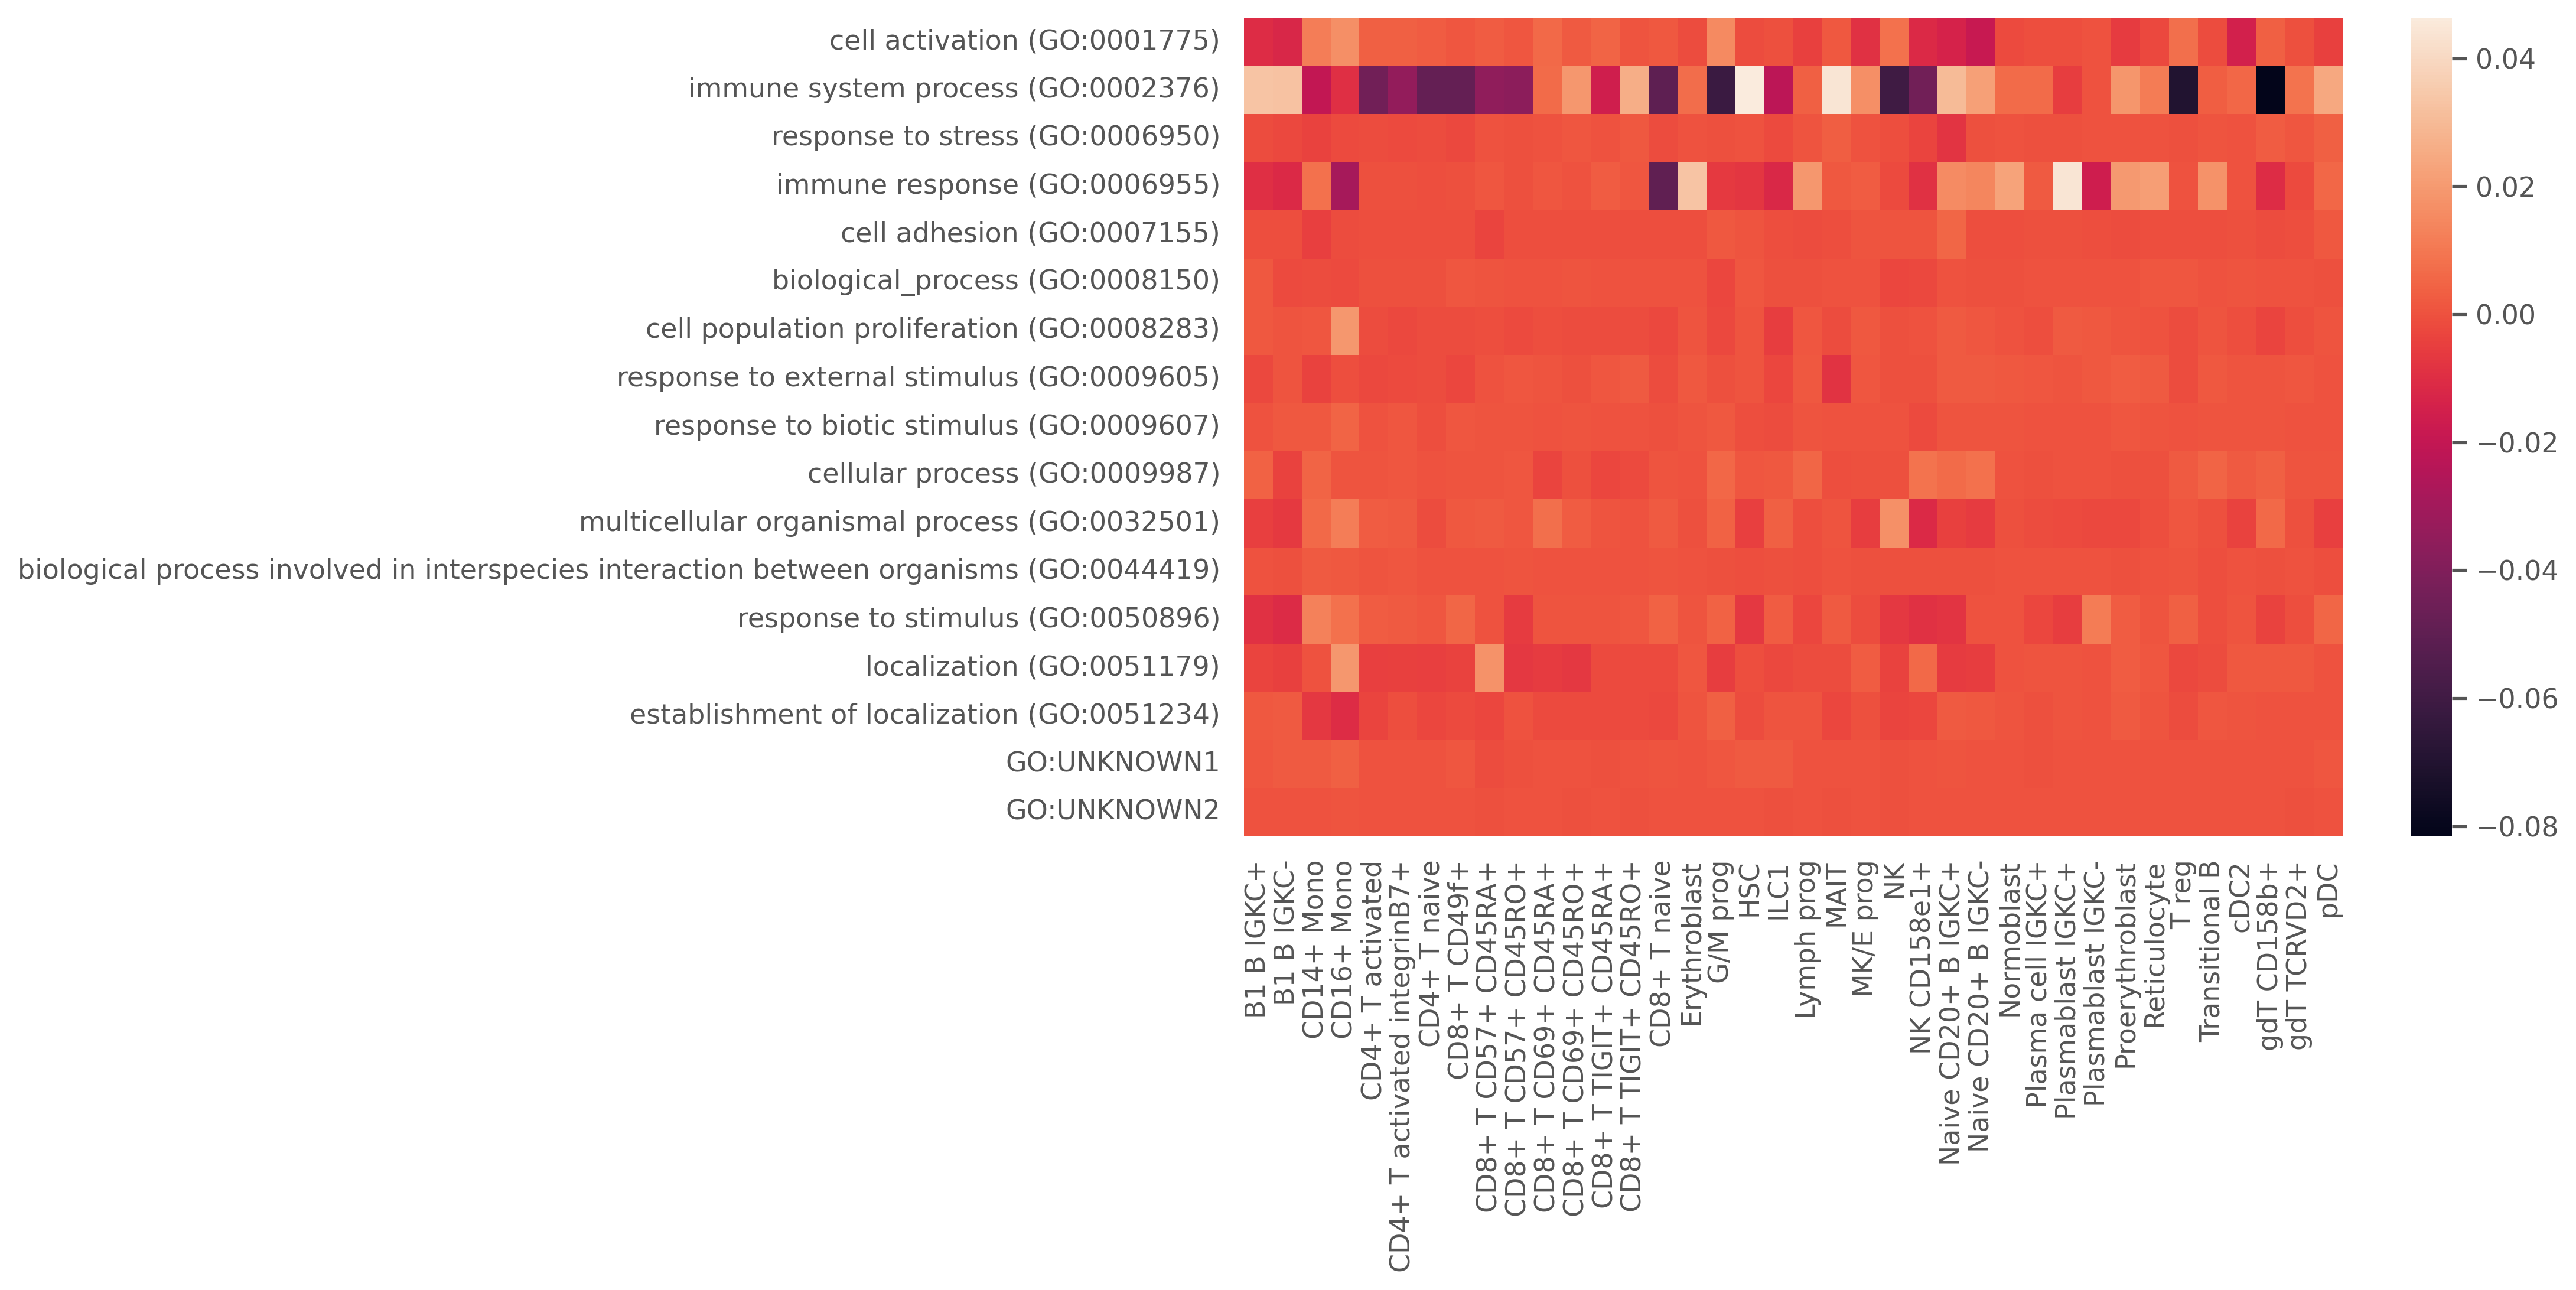

In [82]:
plt.figure(figsize=(10, 6))

sns.heatmap((np.array(go_importances) - np.array(go_importances_pert)).T, xticklabels=cell_types, yticklabels=go_terms)
plt.show()